In [2]:
using LightGraphs, Distributions, DataFrames, ProgressMeter, RCall

In [3]:
srand(20130810)

MersenneTwister(UInt32[0x01332bfa], Base.dSFMT.DSFMT_state(Int32[-1772545288, 1073534108, 1077066014, 1072915095, -2146195133, 1072843413, 301764553, 1073404181, 750472136, 1073628106  …  -1491411563, 1073194977, 716119449, 1072893711, 1632331784, 758890923, 1433693833, -13012230, 382, 0]), [1.98619, 1.94589, 1.75428, 1.61862, 1.16592, 1.5365, 1.47187, 1.92902, 1.83274, 1.72863  …  1.67703, 1.52454, 1.16355, 1.10165, 1.20014, 1.30681, 1.41491, 1.39147, 1.69956, 1.56541], 382)

*Note: This workbook replicates the results from "The chilling effects of network externalities" by Goldenberg, Libai and Muller (2007). This is a self-didactic attempt*

> Two factors influence the transition of a non-adopter to an adopter:
- External factors: Some probability $a$ exists such that in a given time period, an individual will be influenced by external influence mechanisms such as advertising, mass media, and other marketing efforts, to adopt the innovative product
- Internal factors: Some probability $b$ exists such that during a given time period, an individual will be affected by an interaction (e.g., word of mouth) with exactly one other individual who has already adopted the product

> Let the number of cumulative adopters at time $t$ in a market of size $N$ be $x(t)$ and the threshold of an individual $i$ be $h_i$. If $i$ is connected to $m_i(t)$ adopters belonging to her personal network, her probability of adoption is:
$p_i(t) = 1 - (1 - a)(1 - b)^{m_i(t)}$ if $x(t)/N > h_i$ and 0 otherwise.

> In order to compare growth processes with and without network effects, we chose to express our measure as the ratio of the NPV of the growth process with and without network effects. Thus, we compute the NPV for the non-externalities case and for the externalities case using a 10% discount rate per period, which is a reasonable yearly rate for many
markets and fixed profit margins. 

> We assume that the threshold distribution follows a truncated normal distribution with mean $\mu$ and standard deviation $\sigma$.

It follows from the above verbatim from the paper that the parameters are $(a, b, \mu, \sigma)$.

In [4]:
mutable struct Network
    G::LightGraphs.SimpleGraphs.SimpleGraph{Int}
    node_status::BitVector
    threshold::Vector{Float64}
end

In [5]:
function network_externalities_effect(N::Network, node::Int, a::Float64, b::Float64)
    if sum(N.node_status)/nv(N.G) > N.threshold[node]
        n_active_nbrs = sum(N.node_status[neighbors(N.G, node)]) 
        return 1 - (1 - a)*((1 - b)^n_active_nbrs)
    else
        return a
    end
end

network_externalities_effect (generic function with 1 method)

In [6]:
function evolve!(N::Network, a::Float64, b::Float64)
    for node in shuffle(vertices(N.G))
        if rand(Uniform()) < network_externalities_effect(N, node, a, b)
            N.node_status[node] = true
        end
    end
    
    return nothing
end

evolve! (generic function with 1 method)

In [7]:
function evolve!(N::Network, a::Float64)
    for node in shuffle(vertices(N.G))
        if rand(Uniform()) < a
            N.node_status[node] = true
        end
    end
    
    return nothing
end

evolve! (generic function with 2 methods)

In [8]:
function simulate(n::Int, z::Int; T = 30, n_realizations = 10)
    parameter_space = [(a, b, mu, sigma) for a in linspace(0.005, 0.05, 5),
                                             b in linspace(0.05, 0.25, 5),
                                             mu in linspace(0.01, 0.2, 5),
                                             sigma in linspace(0.005, 0.025)]
    output = DataFrame(r = Int[], t = Int[], 
                       a = Float64[], b = Float64[], mu = Float64[], sigma = Float64[], 
                       n_engaged_externalities = Int[], n_engaged_no_externalities = Int[])
    
    @showprogress 1 "Simulating..." for (a, b, mu, sigma) in parameter_space
        for r in 1:n_realizations
            g = erdos_renyi(n, z/n)
            threshold = rand(TruncatedNormal(mu, sigma, 0, Inf), nv(g))
            N_externalities = Network(g, falses(nv(g)), threshold)
            N_no_externalities = Network(g, falses(nv(g)), threshold)
            
            for t in 1:T
                evolve!(N_externalities, a, b)
               
                evolve!(N_no_externalities, a)
                
                push!(output, [r, t, a, b, mu, sigma, sum(N_externalities.node_status), sum(N_no_externalities.node_status)])
            end
        end
    end
    
    return output
end

simulate (generic function with 1 method)

In [9]:
result = simulate(625, 8)
@rput result

Simulating...100%|██████████████████████████████████████| Time: 0:09:32


,r,t,a,b,mu,sigma,n_engaged_externalities,n_engaged_no_externalities
1,1,1,0.005,0.05,0.01,0.005,3,6
2,1,2,0.005,0.05,0.01,0.005,6,8
3,1,3,0.005,0.05,0.01,0.005,11,8
4,1,4,0.005,0.05,0.01,0.005,23,10
5,1,5,0.005,0.05,0.01,0.005,34,13
6,1,6,0.005,0.05,0.01,0.005,64,14
7,1,7,0.005,0.05,0.01,0.005,85,17
8,1,8,0.005,0.05,0.01,0.005,121,19
9,1,9,0.005,0.05,0.01,0.005,157,20
10,1,10,0.005,0.05,0.01,0.005,206,22


In [13]:
R"""
library(tidyverse)
result_summ <- result %>% group_by(a, b, mu, sigma, t) %>% 
                          summarize(Avg_Engaged_Externalities = mean(n_engaged_externalities), 
                                    Avg_Engaged_No_Externalities = mean(n_engaged_no_externalities))

"""

RCall.RObject{RCall.VecSxp}
# A tibble: 187,500 x 7
# Groups:   a, b, mu, sigma [?]
         a      b     mu   sigma     t Avg_Engaged_Extern~ Avg_Engaged_No_Exte~
     <dbl>  <dbl>  <dbl>   <dbl> <int>               <dbl>                <dbl>
 1 0.00500 0.0500 0.0100 0.00500     1                2.20                 3.30
 2 0.00500 0.0500 0.0100 0.00500     2                5.40                 6.10
 3 0.00500 0.0500 0.0100 0.00500     3               11.2                  8.60
 4 0.00500 0.0500 0.0100 0.00500     4               19.0                 12.6 
 5 0.00500 0.0500 0.0100 0.00500     5               28.7                 14.8 
 6 0.00500 0.0500 0.0100 0.00500     6               45.6                 16.7 
 7 0.00500 0.0500 0.0100 0.00500     7               62.4                 19.0 
 8 0.00500 0.0500 0.0100 0.00500     8               87.4                 22.4 
 9 0.00500 0.0500 0.0100 0.00500     9              118                   25.5 
10 0.00500 0.0500 0.0100 0.00500    

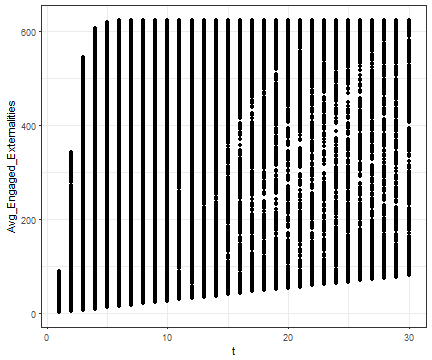

RCall.RObject{RCall.VecSxp}


In [21]:
R"""
ggplot(data = result_summ, aes(x = t), group = c(a, b, mu, sigma)) +
    geom_point(aes(y = Avg_Engaged_Externalities)) +
    theme_bw()

"""

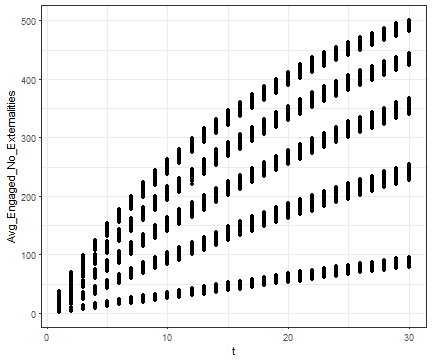

RCall.RObject{RCall.VecSxp}


In [22]:
R"""
ggplot(data = result_summ, aes(x = t), group = c(a, b, mu, sigma)) +
    geom_point(aes(y = Avg_Engaged_No_Externalities)) +
    theme_bw()

"""